<a href="https://colab.research.google.com/github/Rania-chetoui/EEG-Signal-Processing/blob/main/EEGSIG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analyse Spectrale dun signal EEG réelle

In [2]:
pip install spectrum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.2/750.2 kB 20.8 MB/s eta 0:00:00
  Created wheel for spectrum: filename=spectrum-0.9.0-cp311-cp311-linux_x86_64.whl size=236751 sha256=ef8b9c5d4ebd8965fa1f46da60cef003d3f5690197310161fc85c9690ad10f07
  Stored in directory: /root/.cache/pip/wheels/c0/9c/de/eb558fbd03ea1540d3c908f23681f57f9d9e8c2a5cd08d6f42
Successfully built spectrum



 Analyse Spectrale dun signal EEG réelle

Mounted at /content/drive
Traitement du fichier : s01.csv
Signal original :  0    0.987544
1    0.961610
2    0.863465
3    0.691179
4    0.469106
5    0.242036
6    0.057850
7   -0.055979
8   -0.105036
9   -0.123984
Name: 1, dtype: float64
Signal filtré :  [ 0.00521277  0.04548497  0.18262453  0.44805897  0.75012559  0.89950284
  0.77395608  0.43680884  0.07383534 -0.16577458]


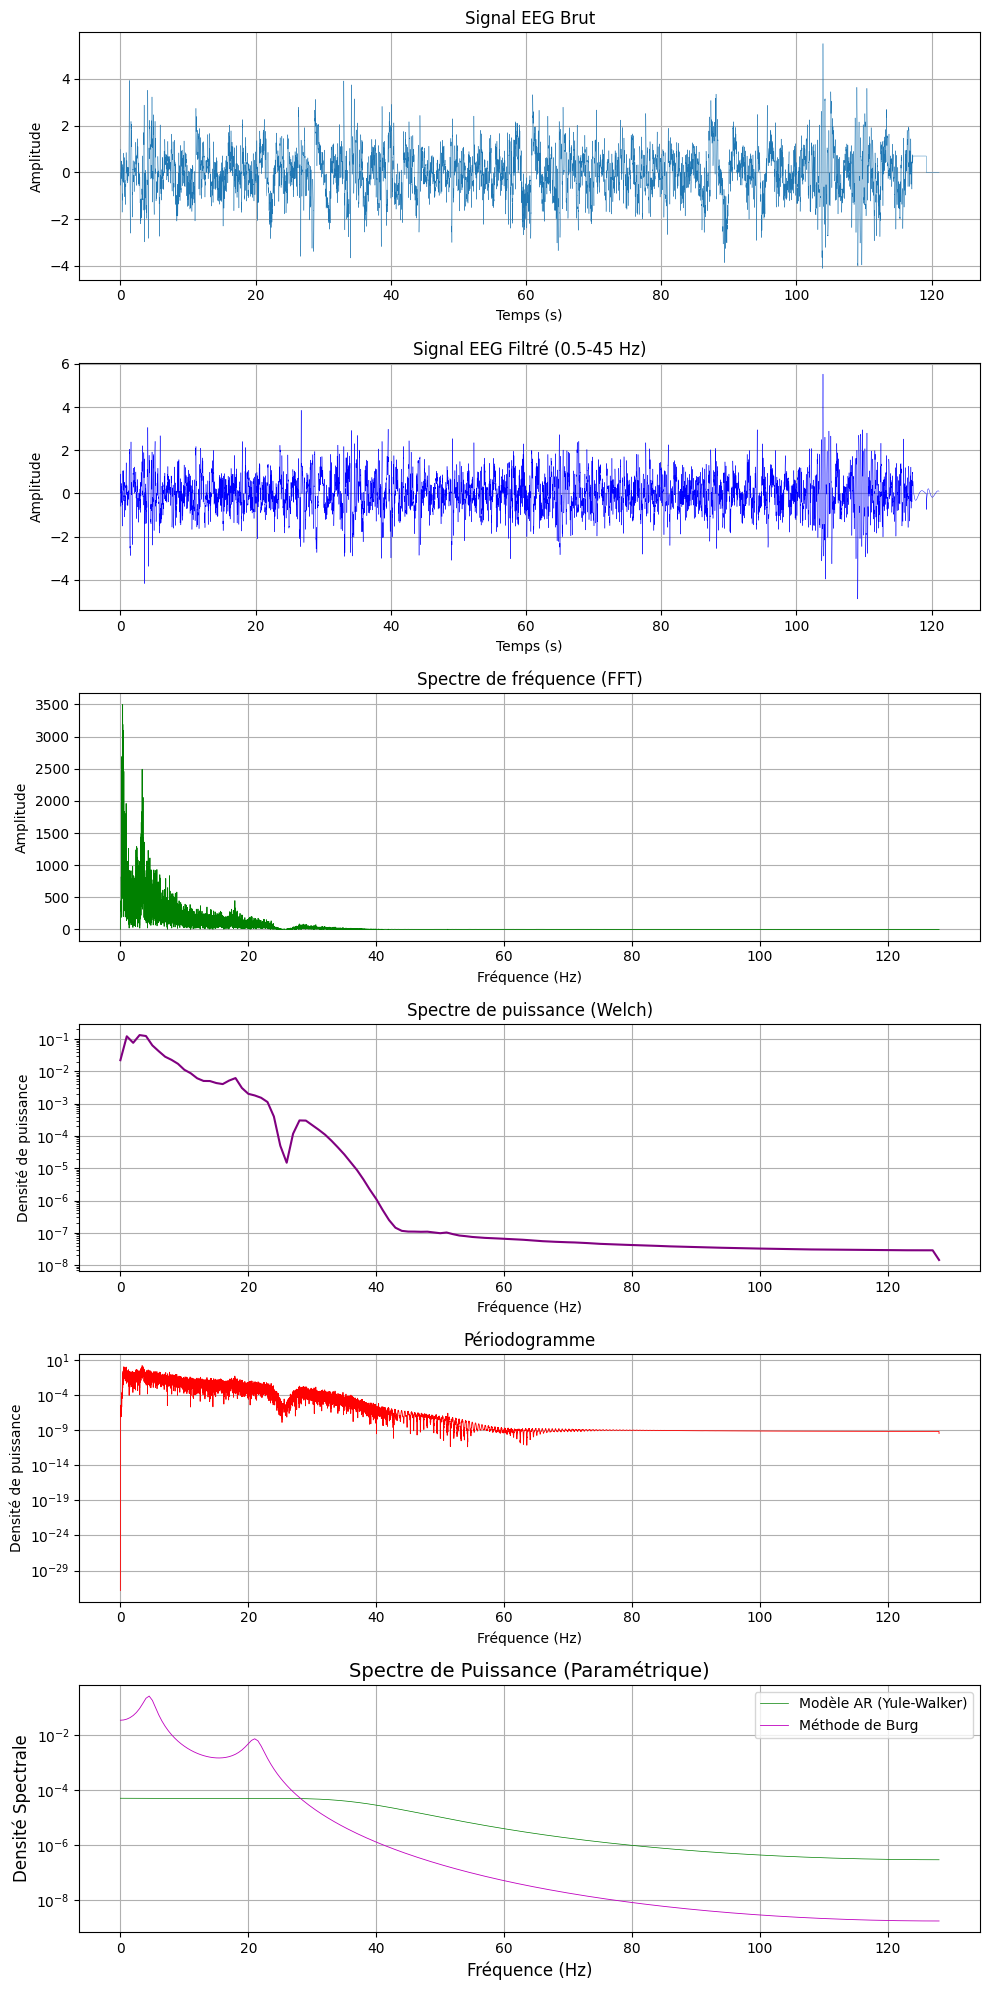

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, welch, periodogram
from numpy.fft import fft, fftfreq
from spectrum import aryule, pburg
from google.colab import drive
drive.mount('/content/drive')
# Fonction de filtrage passe-bande
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

# Dossier contenant les fichiers
folder_path = '/content/drive/MyDrive/sig'
save_plots = True  # Mettre sur False pour afficher les courbes

# Limiter à un fichier pour le test
max_files = 1

for i, filename in enumerate(os.listdir(folder_path)):
    if i >= max_files:
        break
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        print(f"Traitement du fichier : {filename}")

        # Lecture des données
        data = pd.read_csv(file_path, header=None)
        col_time = data.iloc[:, 0]
        col_signal = data.iloc[:, 1]

        # Nettoyage des données
        col_time = pd.to_numeric(col_time, errors='coerce').dropna()
        col_signal = pd.to_numeric(col_signal, errors='coerce').dropna()
        col_signal = (col_signal - col_signal.mean()) / col_signal.std()  # Normalisation

        # Ajustement des tailles
        min_len = min(len(col_time), len(col_signal))
        col_time = col_time.iloc[:min_len]
        col_signal = col_signal.iloc[:min_len]

        # Fréquence d'échantillonnage
        fs = 256  # Hz
        lowcut, highcut = 0.5, 45  # Fréquences de coupure
        t = np.linspace(0, len(col_signal) / fs, len(col_signal))

        # Filtrage
        filtered_signal = butter_bandpass_filter(col_signal, lowcut, highcut, fs)
        print("Signal original : ", col_signal[:10])  # Afficher les premiers éléments avant le filtrage
        print("Signal filtré : ", filtered_signal[:10])  # Afficher les premiers éléments après le filtrage


        # Transformée de Fourier rapide (FFT)
        N = len(col_signal)
        freq = fftfreq(N, d=1/fs)  # Fréquences associées
        fft_values = np.abs(fft(col_signal))  # Valeurs FFT

        # Méthode de Welch pour le spectre de puissance
        f_welch, Pxx_welch = welch(col_signal, fs, nperseg=256)

        # Périodogramme
        f_periodogram, Pxx_periodogram = periodogram(filtered_signal, fs)
        # Estimations spectrales paramétriques(2 méthodes )
        ar_order = 4
        # Méthode Yule-Walker
        ar_coeffs, noise_variance, _ = aryule(filtered_signal, ar_order)
        psd_ar_yw = noise_variance / np.abs(np.fft.fft(ar_coeffs, n=512))**2
        freqs_ar_yw = np.linspace(0, fs / 2, len(psd_ar_yw)//2)

        # Méthode de Burg
        p = pburg(filtered_signal, ar_order, NFFT=512, sampling=fs)
        psd_burg = p.psd
        freqs_burg = p.frequencies()

        # Tracé des résultats
        plt.figure(figsize=(10, 20))

        # Signal brut
        plt.subplot(6,1, 1)
        plt.plot(t, col_signal, label='Signal brut', linewidth=0.3)
        plt.title("Signal EEG Brut")
        plt.xlabel("Temps (s)")
        plt.ylabel("Amplitude")
        plt.grid(True)

        # Signal filtré
        plt.subplot(6,1, 2)
        plt.plot(t, filtered_signal, label='Signal filtré', linewidth=0.3, color='blue')
        plt.title(f"Signal EEG Filtré ({lowcut}-{highcut} Hz)")
        plt.xlabel("Temps (s)")
        plt.ylabel("Amplitude")
        plt.grid(True)

        # Transformée de Fourier (FFT)
        plt.subplot(6,1, 3)
        plt.plot(freq[:N // 2], fft_values[:N // 2], linewidth=0.6, color='green')
        plt.title("Spectre de fréquence (FFT)")
        plt.xlabel("Fréquence (Hz)")
        plt.ylabel("Amplitude")
        plt.grid(True)

        # Méthode de Welch
        plt.subplot(6,1, 4)
        plt.semilogy(f_welch, Pxx_welch, color='purple')
        plt.title("Spectre de puissance (Welch)")
        plt.xlabel("Fréquence (Hz)")
        plt.ylabel("Densité de puissance")
        plt.grid(True)

        # Périodogramme
        plt.subplot(6,1, 5)

        plt.semilogy(f_periodogram, Pxx_periodogram, label="Périodogramme", color='red', linewidth=0.6)
        plt.title("Périodogramme")
        plt.xlabel("Fréquence (Hz)")
        plt.ylabel("Densité de puissance")
        plt.grid(True)
        # Estimations spectrales paramétriques
        plt.subplot(6,1, 6)
        plt.semilogy(freqs_ar_yw, psd_ar_yw[:len(freqs_ar_yw)], label="Modèle AR (Yule-Walker)", color='g', linewidth=0.5)
        plt.semilogy(freqs_burg, psd_burg, label="Méthode de Burg", color='m', linewidth=0.6)
        plt.title("Spectre de Puissance (Paramétrique)", fontsize=14)
        plt.xlabel("Fréquence (Hz)", fontsize=12)
        plt.ylabel("Densité Spectrale", fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if save_plots:
            plt.savefig(f"{filename}_all_results.png")
        else:
            plt.show()
